# Optimizing the KSD

In [1]:
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("../../learning_particle_gradients/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


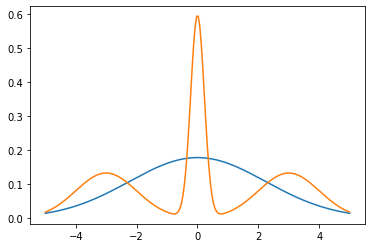

In [2]:
proposal = distributions.Gaussian(0, 5)
target = distributions.GaussianMixture([-3, 0, 3], [1, 0.05, 1], [1,1,1])
sizes = [1]
# sizes = [8, 8, 8, 8]

plot.plot_fun(proposal.pdf)
plot.plot_fun(target.pdf, label="Target")

# Train

In [3]:
learning_rate = 0.1
learner = kernel_learning.KernelLearner(key, 
                                        target, 
                                        sizes,
                                        kernels.get_rbf_kernel(1, dim=sizes[-1]),
                                        learning_rate,
                                        lambda_reg=0,
                                        scaling_parameter=False)

In [4]:
print("Training kernel to optimize KSD...")
sample = proposal.sample(400)
learner.train(sample, n_steps=100)

Training kernel to optimize KSD...


100%|██████████| 100/100 [00:03<00:00, 32.85it/s]


In [5]:
samples = proposal.sample(500)
phistar = learner.get_phistar(learner.get_params(), samples)
def optimal_phistar(x):
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x)
phistar_rbf = stein.get_phistar(kernels.get_rbf_kernel(1), target.logpdf, samples)

In [ ]:
# plot the stein gradient
grid_n = 100
grid = np.linspace(-5, 5, grid_n).reshape(grid_n, 1)
fig, ax = plt.subplots(figsize=[7,7])
plt.plot(grid, vmap(optimal_phistar)(grid), label="KL gradient \\nabla logp/logq")
plt.plot(grid, vmap(phistar)(grid)*15, label="learned_phistar (scaled)")
# plt.plot(grid, vmap(phistar_rbf)(grid), label="rbf phistar")

plt.legend()

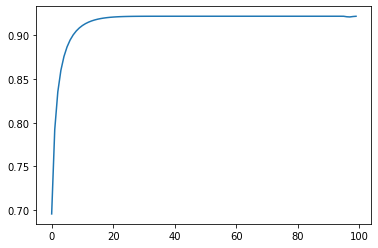

In [8]:
plt.plot(learner.rundata["training_ksd"])

## plot learned kernel

In [9]:
params = learner.opt.get_params(learner.optimizer_state)
learned_kernel = learner.get_kernel(params)

s = proposal.sample(100)
learned_kernel(s[4], s[10])

DeviceArray(0.01611619, dtype=float32)

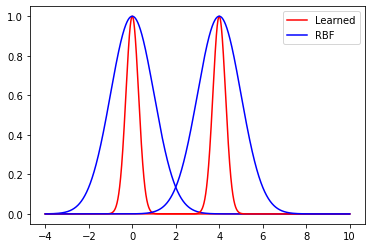

In [11]:
if proposal.d == 1:
    ngrid = 10**4
    grid = np.linspace(-4, 10, ngrid).reshape(ngrid,1)
    x = np.array([0.])
    plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), label="Learned", color="r")
    plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), label="RBF", color="b")
    x = np.array([4.])
    plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), color="r")
    plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), color="b")

    plt.legend()
elif proposal.d == 2:
    fig, ax = plt.subplots(figsize=[7,7])
    x = np.array([0, 0])
    def kernfunx(x_): return learned_kernel(x, x_)
#     def rbfx(x_): return kernels.get_rbf_kernel(1)(x, x_)
    plot.plot_pdf_2d(kernfunx, lims=(-10, 10), label="Learned Kernel", ax=ax)
#     plot.plot_pdf_2d(rbfx, lims=(-10, 10), label="RBF", ax=ax)